# Experiments Gaussian HHM

In [1]:
from dynamax.hidden_markov_model import GaussianHMM
from dynamax.hidden_markov_model import DiagonalGaussianHMM
from dynamax.hidden_markov_model import SphericalGaussianHMM
from dynamax.hidden_markov_model import SharedCovarianceGaussianHMM
import matplotlib.pyplot as plt
import hmm_datasets as hd
import gauss_hmm as gh
import jax.random as jr
import jax.numpy as jnp
import os

In [2]:
# Inputs for gathering the data
path = './data/stocks'
old_first = True
start = '2022-01-01'
end = '2022-12-31'
sep = '_'
period_len = 60
stocks = hd.StockData(path = path,
                      start = start,
                      end = end, 
                      old_first = old_first,
                      sep=sep)

# Inputs for training the model
key = jr.PRNGKey(10)
init_method = 'prior'

## Log returns using Adj Close price

* `mkt_ret` (jnp.array) contains the returns of all stocks in one table. Shape is (batches, period_len, attributes)
* `stk_ret` (Dict) is a dictionary with arrays containing the returns of each stock series. The shape of each array is (batches, period_len, attributes)

In [3]:
# Log return data
returns = stocks.get_log_returns()
mkt_ret = hd.join(returns)
mkt_ret = hd.create_batches(mkt_ret.to_numpy(),
                                  period_len = period_len,
                                  old_first = old_first)
stk_ret = {}
for s in returns.keys():
    stk_ret[s] = hd.create_batches(returns[s].to_numpy(), period_len = period_len, old_first = old_first)

### Create folds using one-batch-out
* `mkt_folds` (list). List containing the folds for mkt_ret.
* `stk_folds` (Dict). Dictionary with lists. Each list contains the fold of a stock series.

In [4]:
# Input: Embargo parameter 
# (See Lopez de Prado - Advances in Financial Machine Learning, Chapter 7)
e = 5

In [5]:
# Folds for mkt_ret
mkt_folds = hd.make_folds(mkt_ret, e)

In [6]:
# Folds for each stock
stk_folds = {}
for s in stk_ret:
    stk_folds[s] = hd.make_folds(stk_ret[s], e)

### Find the number of hidden states using cross-validation (whole market interpretation)

**NOTE**: I can't apply product kernel to this approach (there's nothing to compare with!!)

In [ ]:
model = GaussianHMM

In [ ]:
# Using whole market perspective
states = list(range(2, 5))
avgloglike = gh.cross_val_states_em(model, states, mkt_folds, init_method, key)

# Save file
hd.save_checkpoint(avgloglike, './experiments', 'mkt_avgloglike')

In [ ]:
plt.plot(states, avgloglike, '.-', markersize = 16)
plt.xlabel('Number of states')
plt.ylabel('Average validation marginal log prob')
plt.title(f'{model.__name__}')
plt.grid()
plt.show()
plt.close()

In [ ]:
# Train best model for the market as a whole
mkt_num_states = states[jnp.argmax(avgloglike)]
mkt_model, mkt_param, mkt_loglik = gh.fit_model_em(model, mkt_ret, mkt_num_states, init_method, key)

In [ ]:
# Save model
mkt_dict = {}
mkt_dict['model'] = mkt_model
mkt_dict['param'] = mkt_param
mkt_dict['loglik'] = mkt_loglik
hd.save_checkpoint(mkt_dict, './experiments/', 'mkt_model')

### Find the number of hidden states using cross-validation (stock-wise)

In [7]:
model = GaussianHMM
states = list(range(2, 11))
chk_dir = './experiments'
chk_name = 'stk_crossval_chk'

In [8]:
# Run this if there is a previous checkpoint
chk_file = os.path.join(chk_dir, chk_name + '.pkl')
dict_chk = hd.load_checkpoint(chk_file)
chk_sym = dict_chk['avg_ll'].keys()
stk_avg_ll = dict_chk['avg_ll']
stk_num_states = dict_chk['num_states']
count = len(dict_chk['avg_ll'])

In [8]:
# Run this if there is no previous checkpoint
stk_avg_ll = {}
stk_num_states = {}
chk_sym = {}
count = 0

In [9]:
nstocks = len(stk_folds)
for s in stk_folds:
    if s not in chk_sym:
        print(f'\n === Fitting data from {s} === \n')
        # Cross validation for stock s
        stk_avg_ll[s] = gh.cross_val_states_em(model, states, stk_folds[s], init_method, key)
        stk_num_states[s] = states[jnp.argmax(stk_avg_ll[s])]
    
        # Save checkpoint if necessary
        count = count + 1
        #if count % 5 == 0:
        print(' === Saving checkpoint ===')
        dict_chk = {'avg_ll':stk_avg_ll, 'num_states': stk_num_states}
        hd.save_checkpoint(dict_chk, chk_dir, chk_name)
        print(f'\n ===== {nstocks - count} Stocks remaining ===== \n')


 === Fitting data from WMT === 


 === Starting fitting with 2 states === 


 === Starting fitting with 3 states === 


 === Starting fitting with 4 states === 


 === Starting fitting with 5 states === 


 === Starting fitting with 6 states === 


 === Starting fitting with 7 states === 


 === Starting fitting with 8 states === 


 === Starting fitting with 9 states === 


 === Starting fitting with 10 states === 

 === Saving checkpoint ===

 Object saved 


 ===== 1 Stocks remaining ===== 


 === Fitting data from XOM === 


 === Starting fitting with 2 states === 


 === Starting fitting with 3 states === 


 === Starting fitting with 4 states === 


 === Starting fitting with 5 states === 


 === Starting fitting with 6 states === 


 === Starting fitting with 7 states === 


 === Starting fitting with 8 states === 


 === Starting fitting with 9 states === 


 === Starting fitting with 10 states === 

 === Saving checkpoint ===

 Object saved 


 ===== 0 Stocks remaining ===== 

In [10]:
dict_chk = {'avg_ll':stk_avg_ll, 'num_states': stk_num_states}
hd.save_checkpoint(dict_chk, chk_dir, chk_name)


 Object saved 



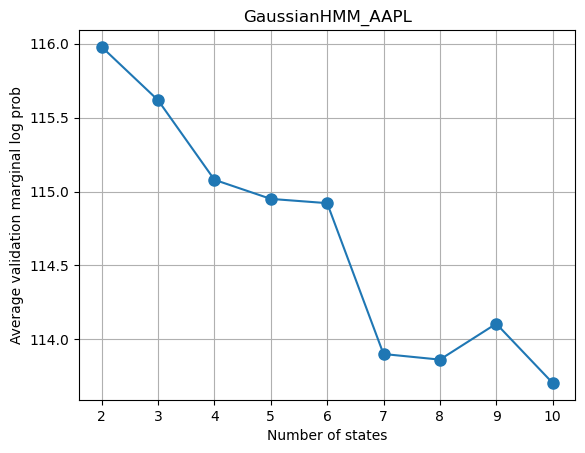

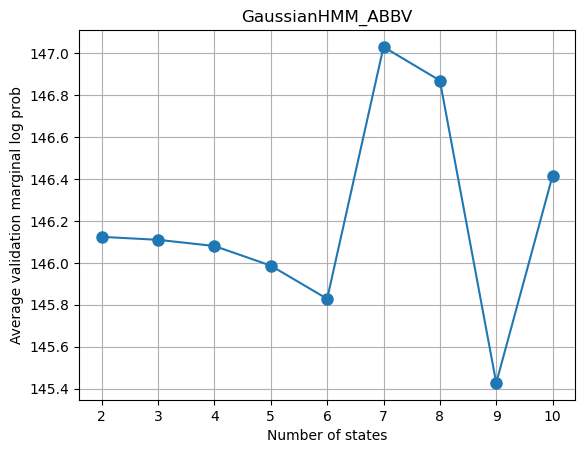

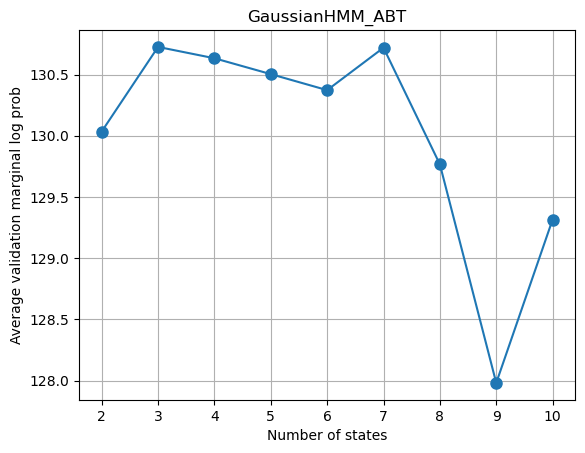

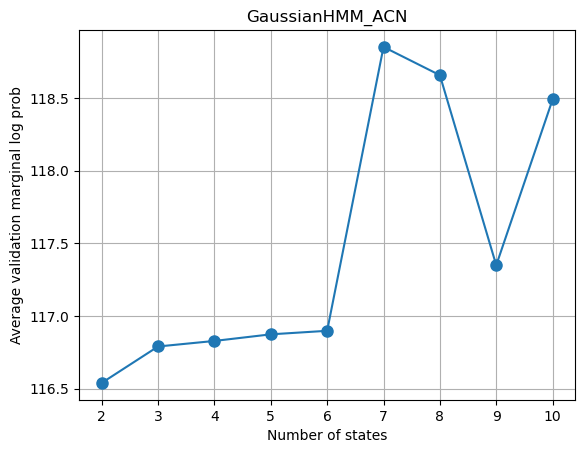

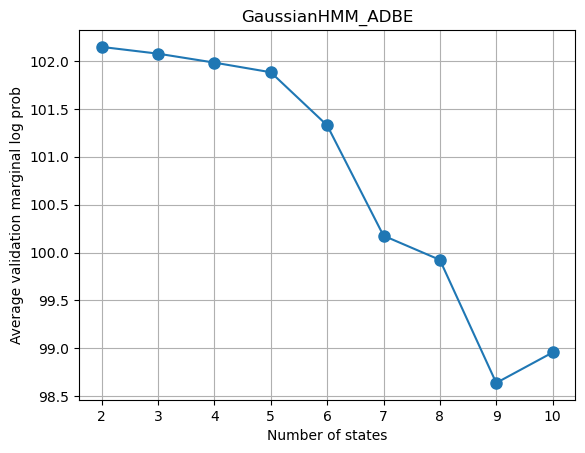

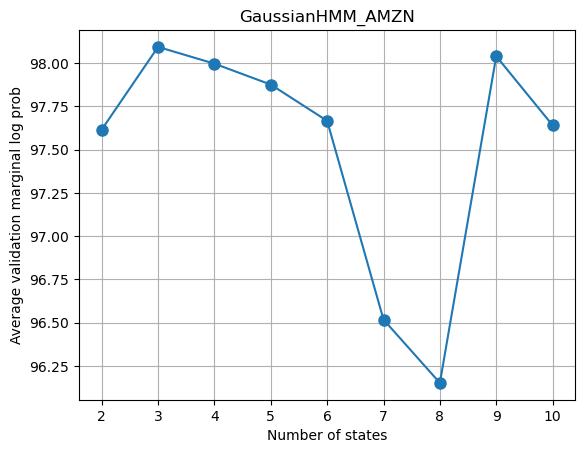

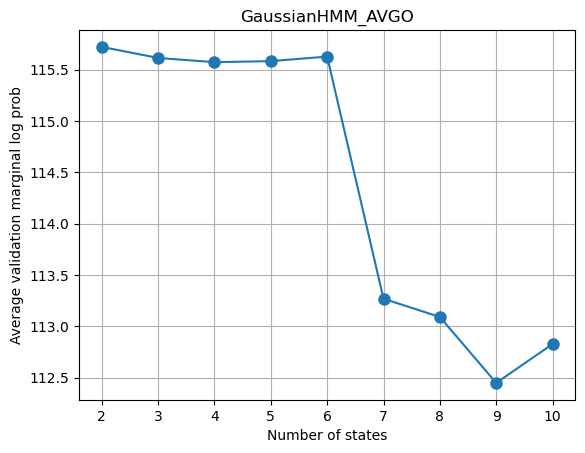

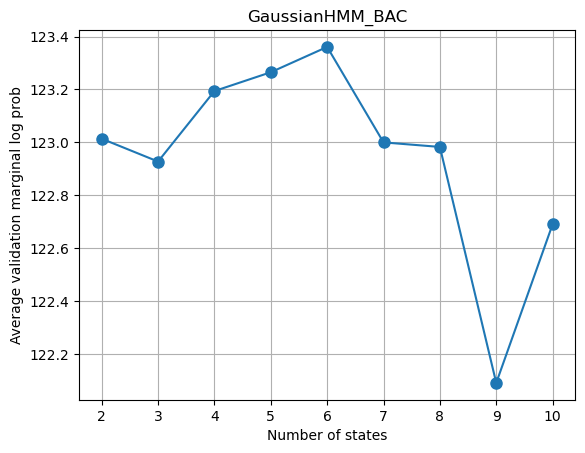

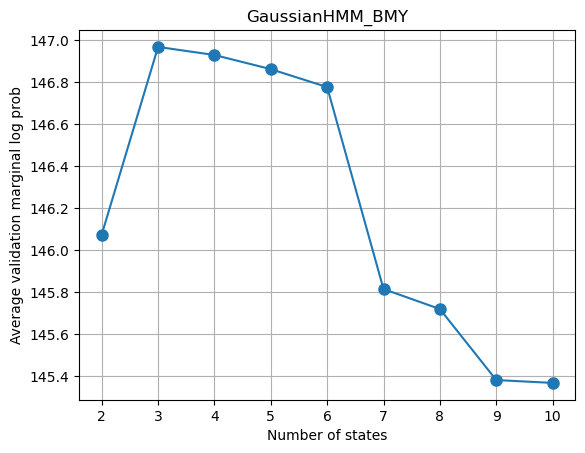

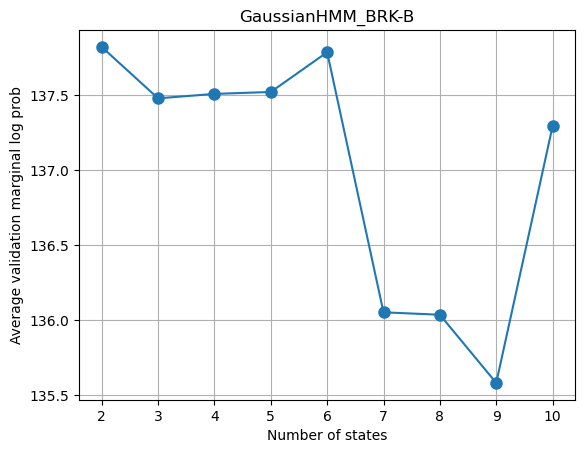

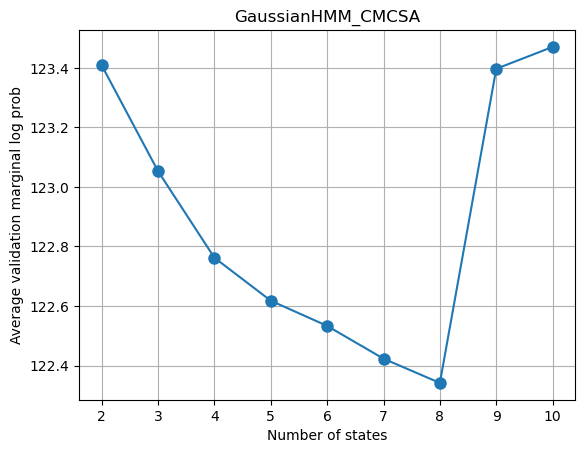

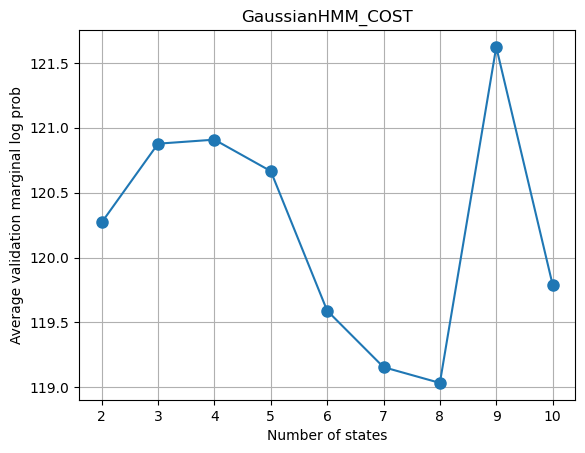

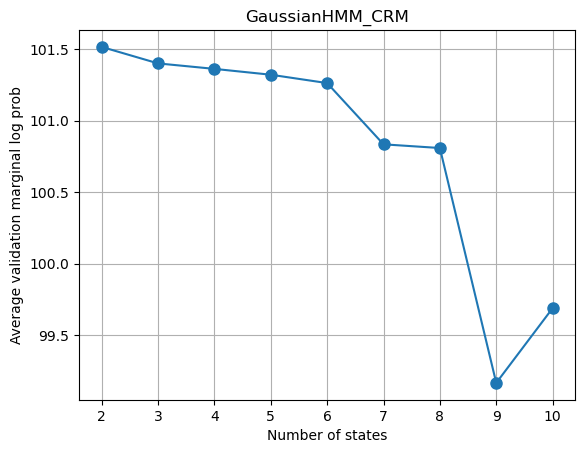

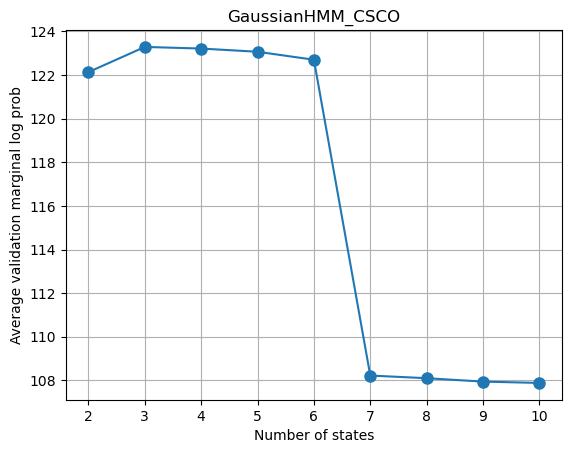

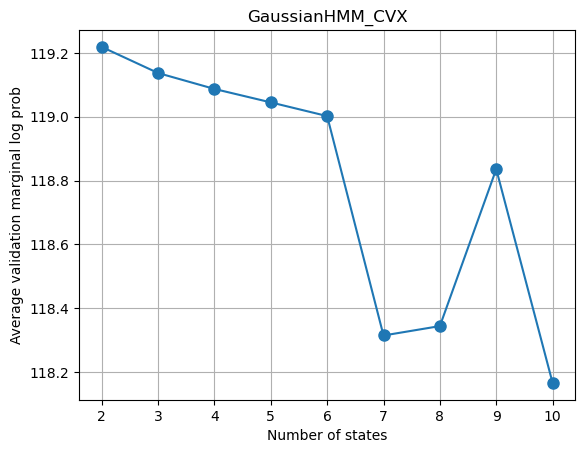

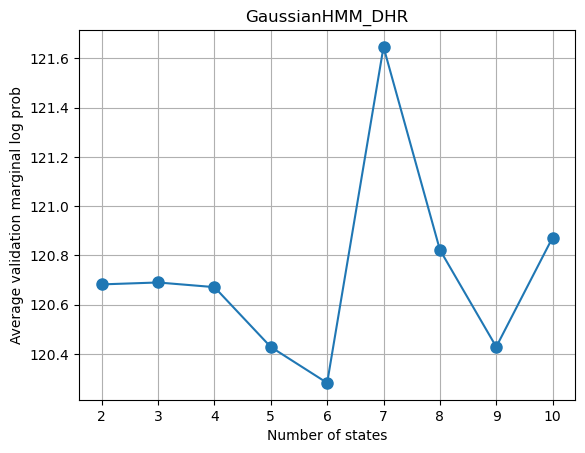

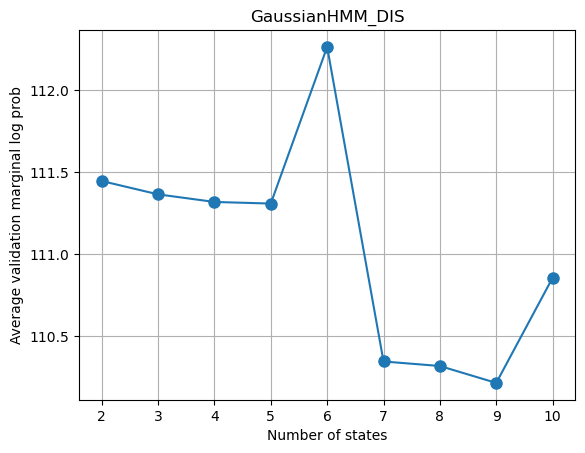

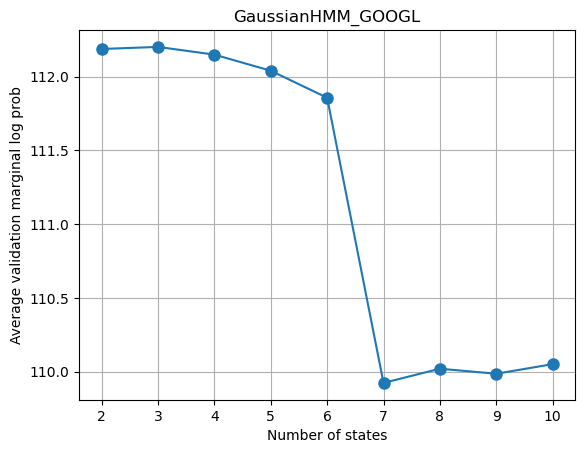

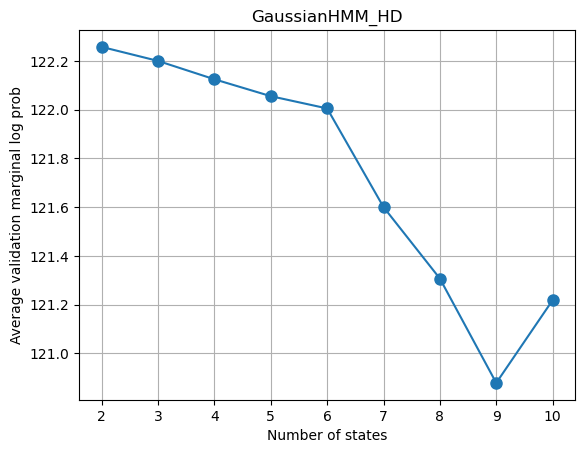

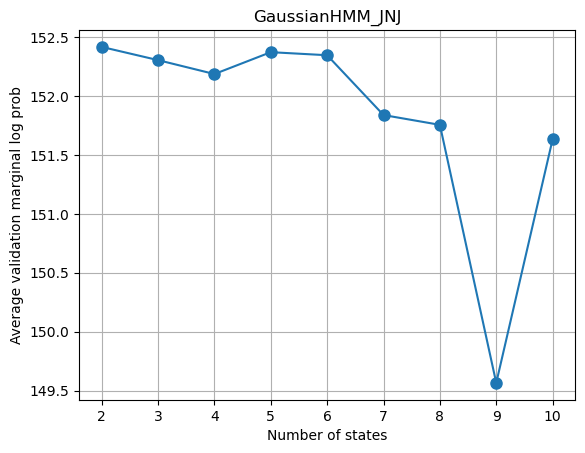

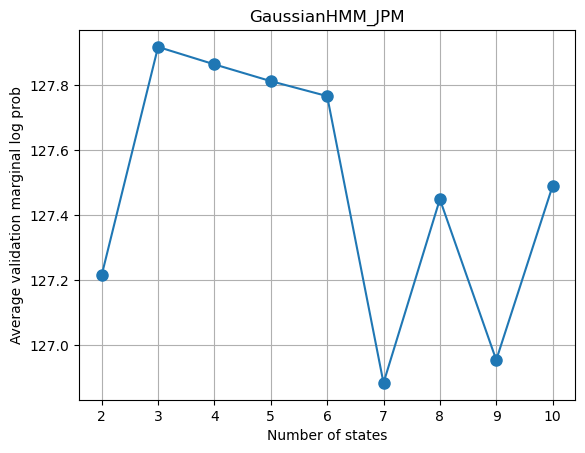

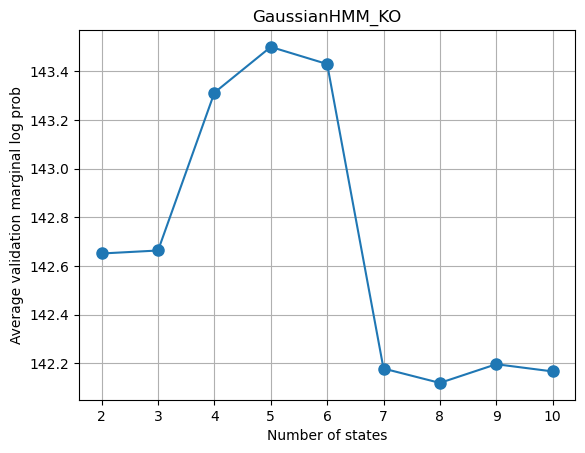

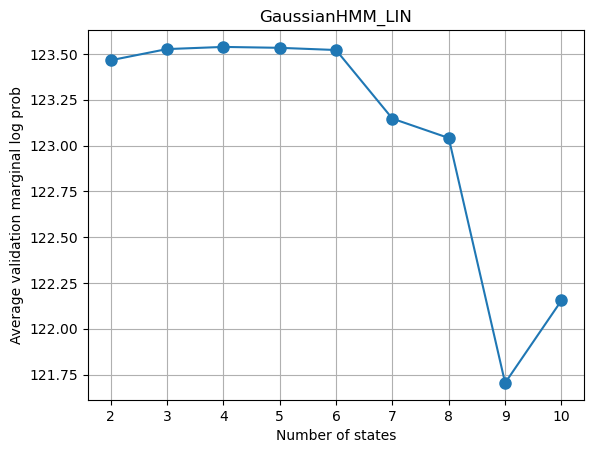

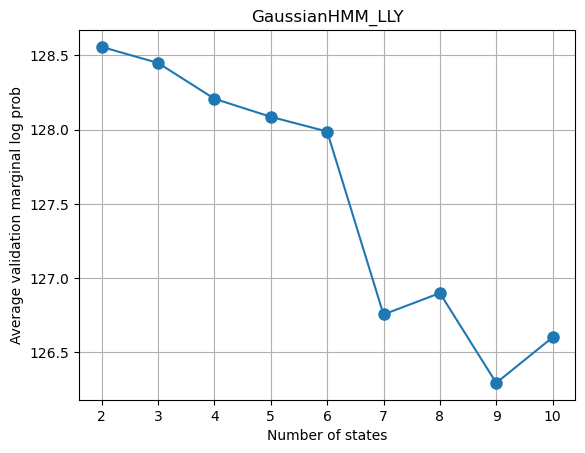

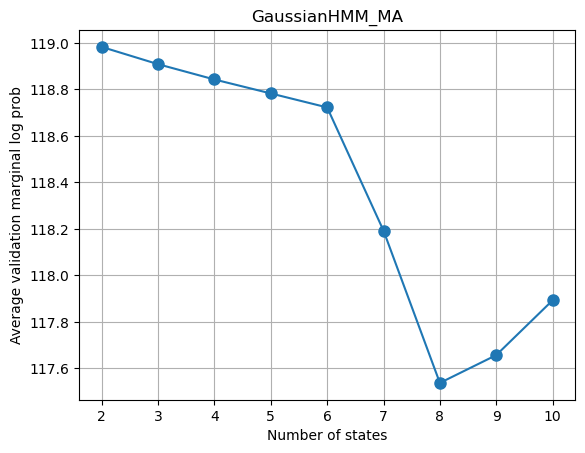

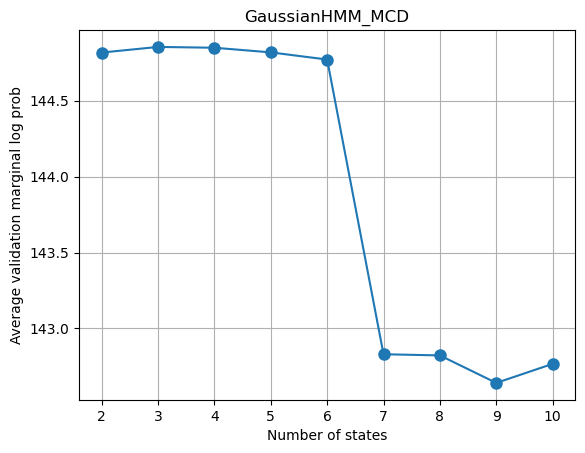

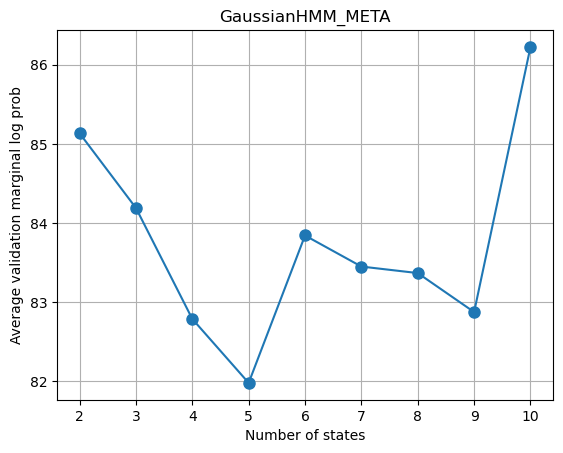

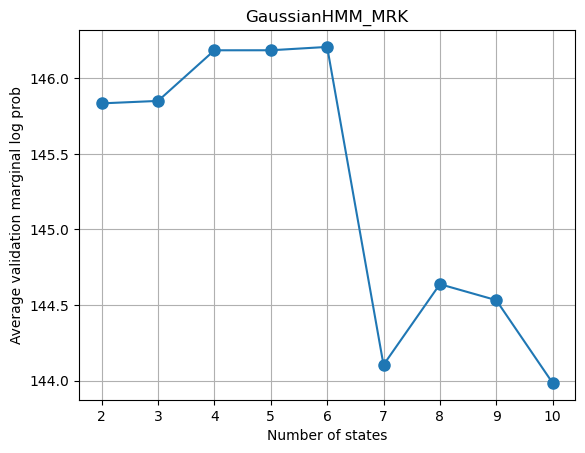

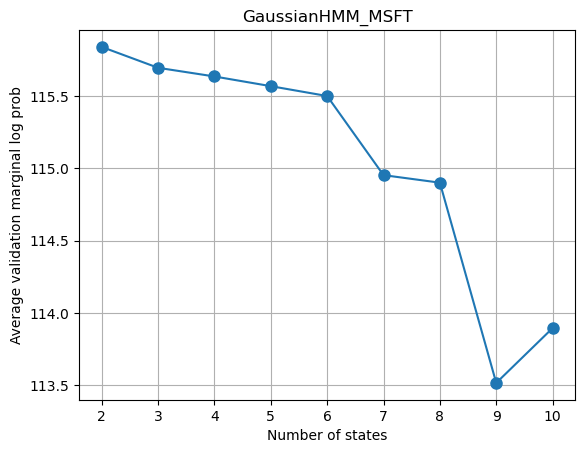

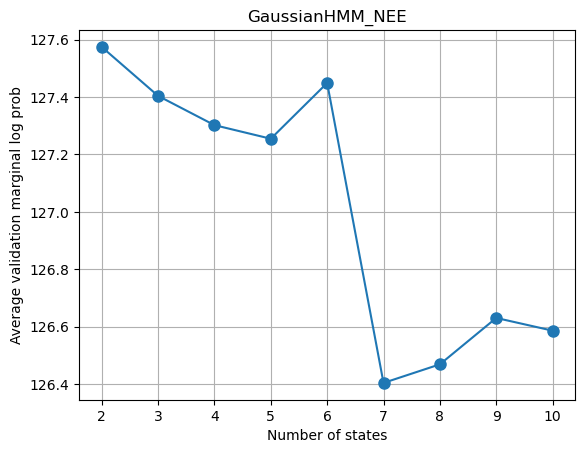

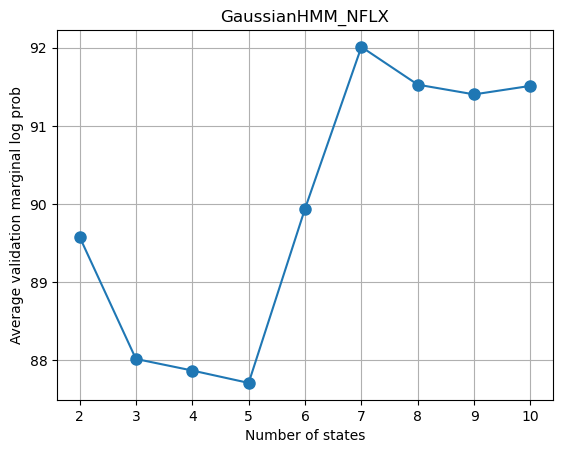

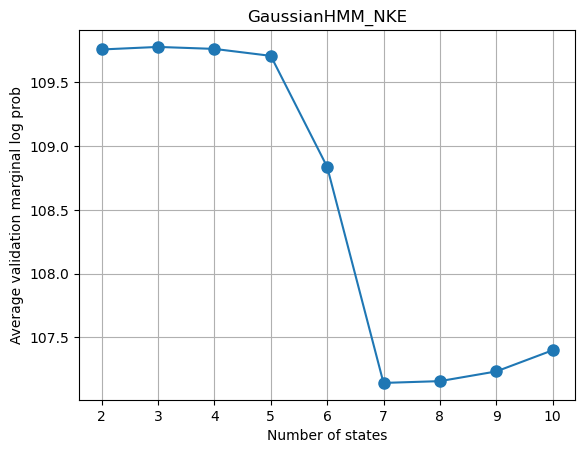

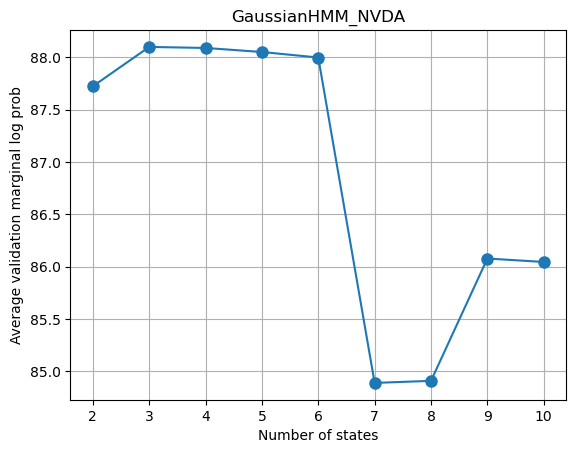

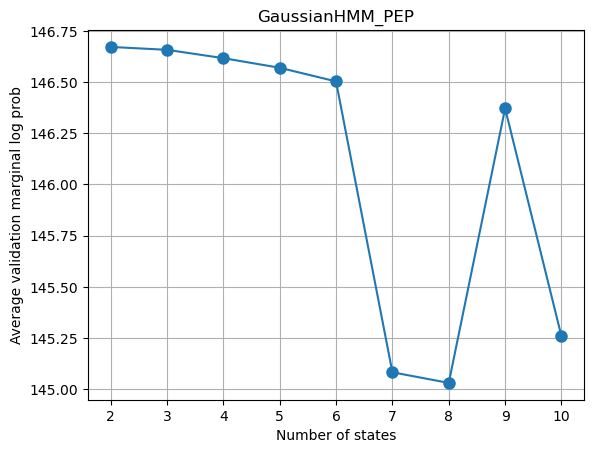

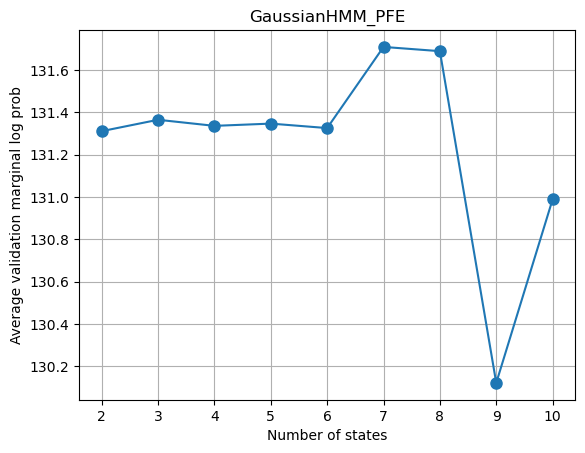

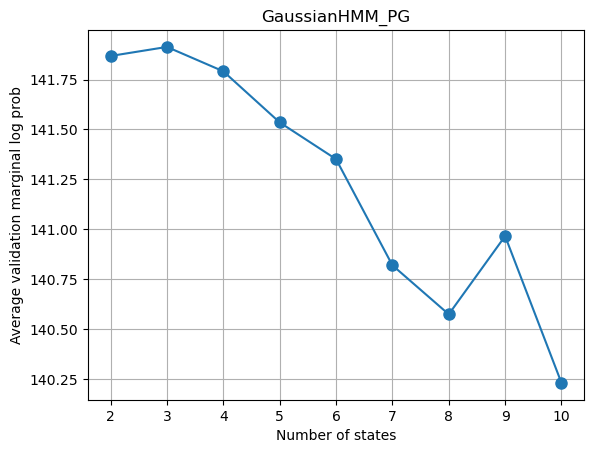

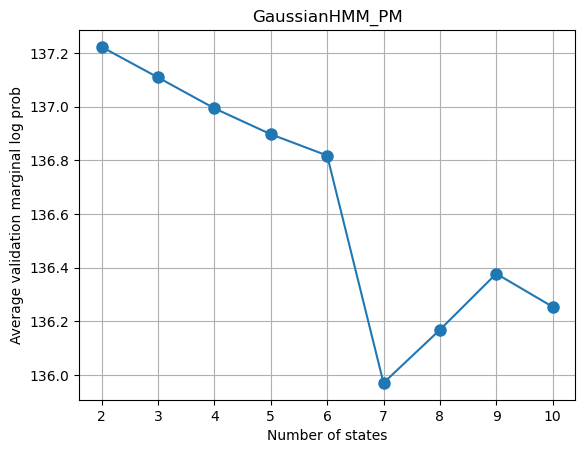

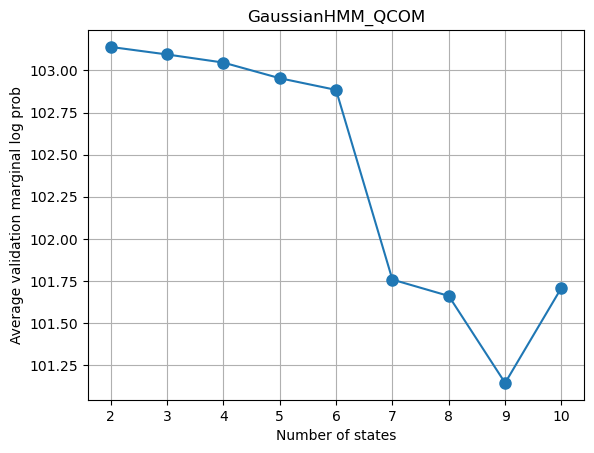

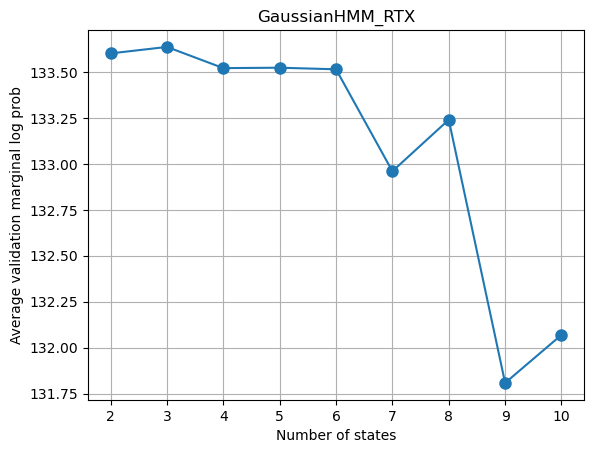

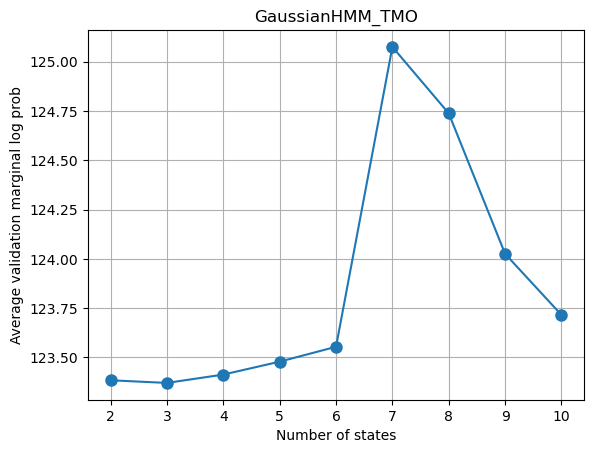

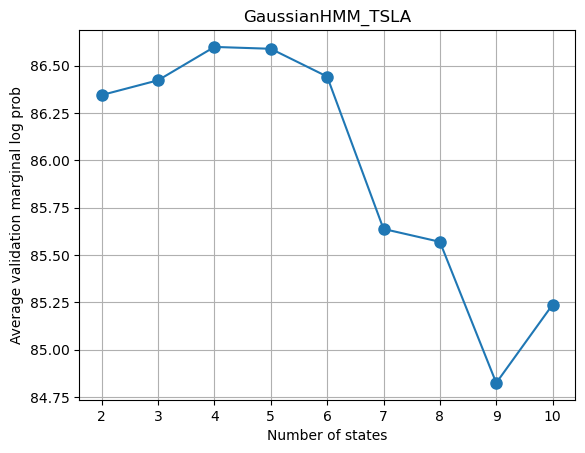

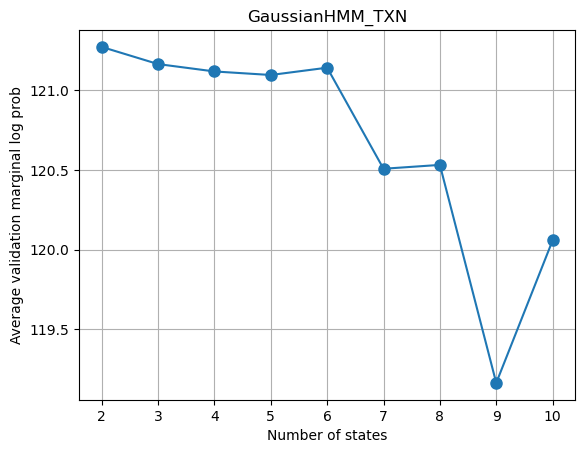

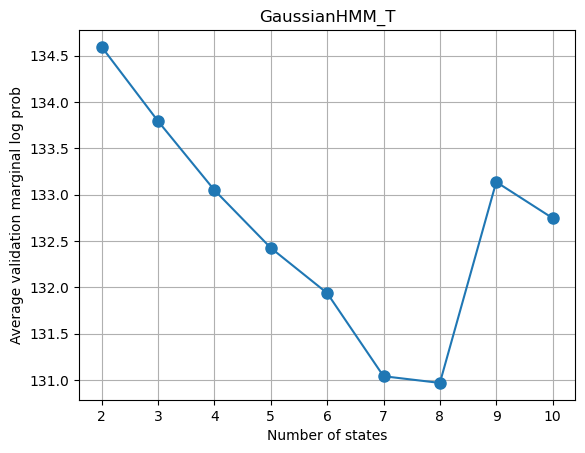

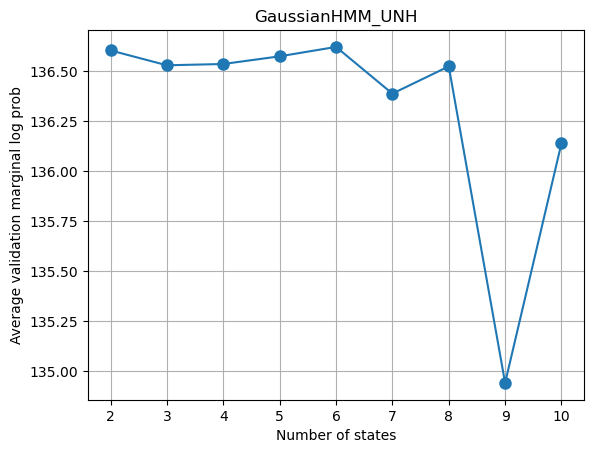

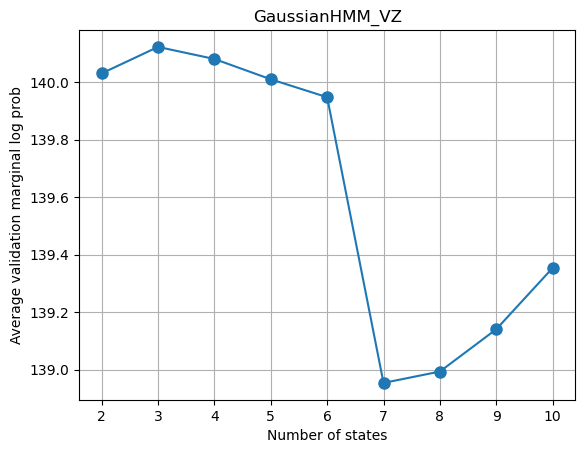

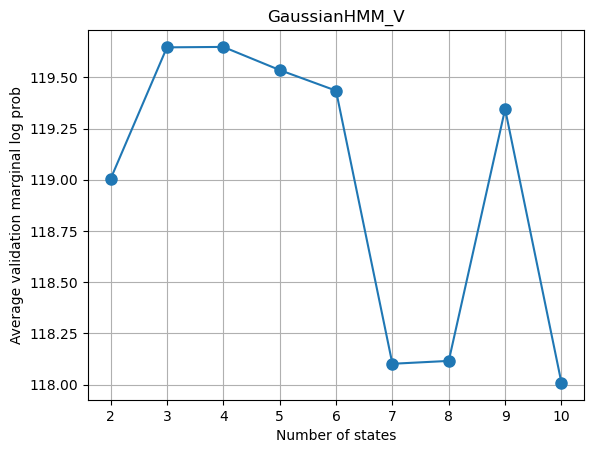

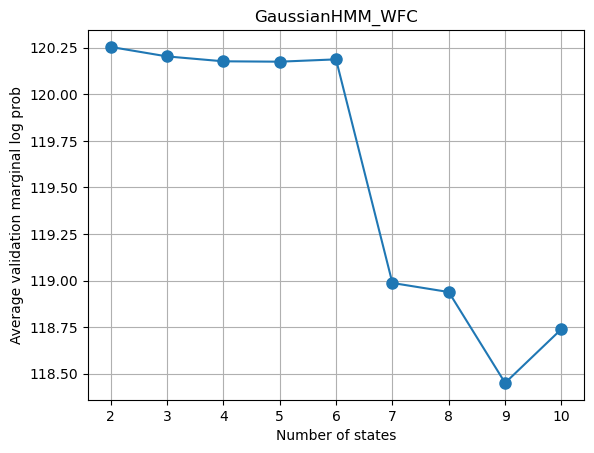

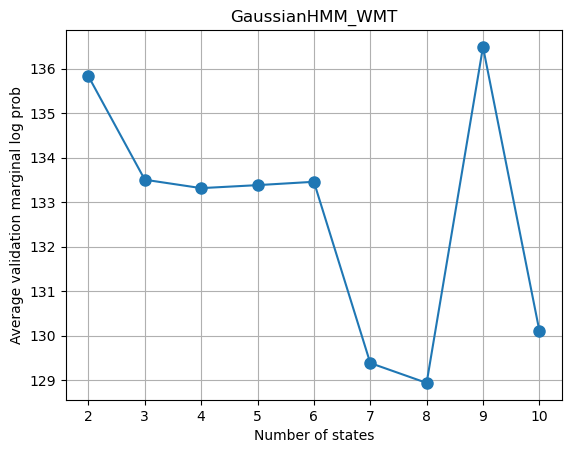

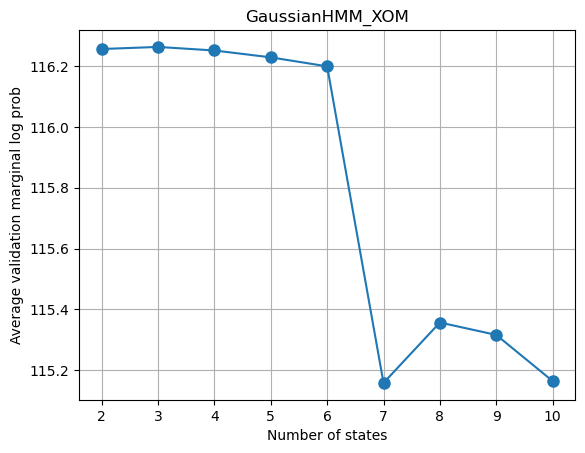

In [11]:
for s in stk_avg_ll:
    plt.plot(states, stk_avg_ll[s], '.-', markersize = 16)
    plt.xlabel('Number of states')
    plt.ylabel('Average validation marginal log prob')
    plt.title(f'{model.__name__}_{s}')
    plt.grid()
    plt.show()
    plt.close()

In [15]:
chk_dir = './experiments/'
chk_name = 'stk_models'

In [16]:
# Fitting best models
count = 0
dict_stk_models = {}
for s in stk_num_states:
    print(f'\n === Fitting data from {s} === \n')
    stk_model, stk_param, stk_loglik = gh.fit_model_em(model, stk_ret[s], stk_num_states[s], init_method, key)
    dict_stk_models[s] = {'model': stk_model, 'param': stk_param, 'loglik': stk_loglik}
    count = count + 1
    hd.save_checkpoint(dict_stk_models, chk_dir, chk_name)
    print(f'\n ===== {nstocks - count} Stocks remaining ===== \n') 


 === Fitting data from AAPL === 


 Object saved 


 ===== 48 Stocks remaining ===== 


 === Fitting data from ABBV === 


 Object saved 


 ===== 47 Stocks remaining ===== 


 === Fitting data from ABT === 


 Object saved 


 ===== 46 Stocks remaining ===== 


 === Fitting data from ACN === 


 Object saved 


 ===== 45 Stocks remaining ===== 


 === Fitting data from ADBE === 


 Object saved 


 ===== 44 Stocks remaining ===== 


 === Fitting data from AMZN === 


 Object saved 


 ===== 43 Stocks remaining ===== 


 === Fitting data from AVGO === 


 Object saved 


 ===== 42 Stocks remaining ===== 


 === Fitting data from BAC === 


 Object saved 


 ===== 41 Stocks remaining ===== 


 === Fitting data from BMY === 


 Object saved 


 ===== 40 Stocks remaining ===== 


 === Fitting data from BRK-B === 


 Object saved 


 ===== 39 Stocks remaining ===== 


 === Fitting data from CMCSA === 


 Object saved 


 ===== 38 Stocks remaining ===== 


 === Fitting data from COST === 


In [ ]:
# Data normalized by open price
norm_stocks = hd.norm_hlc_by_open(stocks, inplace = False)
batches_hlc = hd.batches_norm_hlc_by_open(stocks, period_len)